# YOLOv9 Training for Object Detection

## Step 1. Check GPU availability

In [1]:
!nvidia-smi

Thu Mar  6 16:16:07 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.183.01             Driver Version: 535.183.01   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3070 ...    Off | 00000000:01:00.0 Off |                  N/A |
| N/A   42C    P0              26W /  80W |     16MiB /  8192MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [5]:
import os
HOME = os.getcwd()
print(HOME)

/home/diego/Documents/QStudio/fish/fish_OD


## Step 2. Clone YOLOV9 Repository

In [3]:
!git clone https://github.com/WongKinYiu/yolov9.git
%cd yolov9
!pip install -r requirements.txt -q
!pip install pyyaml

Cloning into 'yolov9'...
remote: Enumerating objects: 781, done.
remote: Total 781 (delta 0), reused 0 (delta 0), pack-reused 781 (from 1)
Receiving objects: 100% (781/781), 3.27 MiB | 6.16 MiB/s, done.
Resolving deltas: 100% (330/330), done.
/home/diego/Documents/QStudio/fish/fish_OD/yolov9

[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


## Step 3. Download YOLOV9 pre-trained yolov9-c-converted.pt weights

In [4]:
!wget -P {HOME}/yolov9/weights -q https://github.com/WongKinYiu/yolov9/releases/download/v0.1/yolov9-c-converted.pt

In [5]:
!ls {HOME}/yolov9/weights -l

total 50272
-rw-rw-r-- 1 diego diego 51477927 feb 27  2024 yolov9-c-converted.pt


## Step 4. Required Folder Structure

The following folder structure is the one that must be used inside the yoloV9 project.
Inside data folder, create another folder called dataset. Inside there you must put the files extracted from Roboflow (train/,valid/,test/)

```plaintext
📂 yolov9/
│── 📂 data/                 # Main dataset folder
│   │── 📂 dataset/
│   │   │── 📂 train/        # Training dataset from Roboflow
│   │   │   │── 📂 images/   # Training images
│   │   │   │── 📂 labels/   # Training labels (.txt format)
│   │   │
│   │   │── 📂 valid/        # Validation dataset from Roboflow
│   │   │   │── 📂 images/   # Validation images
│   │   │   │── 📂 labels/   # Validation labels
│   │   │
│   │   │── 📂 test/         # Testing dataset from Roboflow
│   │   │   │── 📂 images/   # Testing images
│   │   │   │── 📂 labels/   # Testing labels
│   │   │
│   |── dataset.yaml # YOLOv9 dataset configuration file this will be created in step 5
│

...


In [6]:
!ls -l

total 144
drwxrwxr-x 14 diego diego   4096 mar  3 18:17 yolov9
-rw-rw-r--  1 diego diego 139548 mar  4 09:29 yolov9_training.ipynb


## Step 5. Create YAML file for the dataset

In [9]:
import yaml
import os

# Custom representer to force inline (flow) style for lists
def represent_inline_list(dumper, data):
    return dumper.represent_sequence('tag:yaml.org,2002:seq', data, flow_style=True)

yaml.add_representer(list, represent_inline_list)

# Custom string type that will be represented with single quotes
class Quoted(str):
    pass

def quoted_representer(dumper, data):
    return dumper.represent_scalar('tag:yaml.org,2002:str', data, style="'")

yaml.add_representer(Quoted, quoted_representer)

# Define the YAML file path and ensure its directory exists
yaml_path = "./yolov9/data/dataset.yaml"
os.makedirs(os.path.dirname(yaml_path), exist_ok=True)

# Load existing YAML data if file exists; otherwise, start with an empty dict
if os.path.exists(yaml_path):
    with open(yaml_path, "r") as file:
        try:
            data = yaml.safe_load(file) or {}
        except yaml.YAMLError:
            data = {}
else:
    data = {}

# Set the desired values
data["train"] = "./data/dataset/train/images"
data["val"] = "./data/dataset/valid/images"
data["test"] = "./data/dataset/test/images"
data["nc"] = 1
data["names"] = [Quoted("fish")]

# Write the YAML file with the custom formatting
with open(yaml_path, "w") as file:
    yaml.dump(data, file, default_flow_style=False, sort_keys=False)

print("YAML file created/updated successfully!")

YAML file created/updated successfully!


## Step 6. Create a YAML File for the Network Architecture Configuration

In [ ]:
yaml_content = """
# YOLOv9

# parameters
nc: 1  # number of classes
depth_multiple: 1.0  # model depth multiple
width_multiple: 1.0  # layer channel multiple
#activation: nn.LeakyReLU(0.1)
#activation: nn.ReLU()

# anchors
anchors: 3

# YOLOv9 backbone
backbone:
  [
   [-1, 1, Silence, []],  
   
   # conv down
   [-1, 1, Conv, [64, 3, 2]],  # 1-P1/2

   # conv down
   [-1, 1, Conv, [128, 3, 2]],  # 2-P2/4

   # elan-1 block
   [-1, 1, RepNCSPELAN4, [256, 128, 64, 1]],  # 3

   # avg-conv down
   [-1, 1, ADown, [256]],  # 4-P3/8

   # elan-2 block
   [-1, 1, RepNCSPELAN4, [512, 256, 128, 1]],  # 5

   # avg-conv down
   [-1, 1, ADown, [512]],  # 6-P4/16

   # elan-2 block
   [-1, 1, RepNCSPELAN4, [512, 512, 256, 1]],  # 7

   # avg-conv down
   [-1, 1, ADown, [512]],  # 8-P5/32

   # elan-2 block
   [-1, 1, RepNCSPELAN4, [512, 512, 256, 1]],  # 9
  ]

# YOLOv9 head
head:
  [
   # elan-spp block
   [-1, 1, SPPELAN, [512, 256]],  # 10

   # up-concat merge
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 7], 1, Concat, [1]],  # cat backbone P4

   # elan-2 block
   [-1, 1, RepNCSPELAN4, [512, 512, 256, 1]],  # 13

   # up-concat merge
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 5], 1, Concat, [1]],  # cat backbone P3

   # elan-2 block
   [-1, 1, RepNCSPELAN4, [256, 256, 128, 1]],  # 16 (P3/8-small)

   # avg-conv-down merge
   [-1, 1, ADown, [256]],
   [[-1, 13], 1, Concat, [1]],  # cat head P4

   # elan-2 block
   [-1, 1, RepNCSPELAN4, [512, 512, 256, 1]],  # 19 (P4/16-medium)

   # avg-conv-down merge
   [-1, 1, ADown, [512]],
   [[-1, 10], 1, Concat, [1]],  # cat head P5

   # elan-2 block
   [-1, 1, RepNCSPELAN4, [512, 512, 256, 1]],  # 22 (P5/32-large)
   
   
   # multi-level reversible auxiliary branch
   
   # routing
   [5, 1, CBLinear, [[256]]], # 23
   [7, 1, CBLinear, [[256, 512]]], # 24
   [9, 1, CBLinear, [[256, 512, 512]]], # 25
   
   # conv down
   [0, 1, Conv, [64, 3, 2]],  # 26-P1/2

   # conv down
   [-1, 1, Conv, [128, 3, 2]],  # 27-P2/4

   # elan-1 block
   [-1, 1, RepNCSPELAN4, [256, 128, 64, 1]],  # 28

   # avg-conv down fuse
   [-1, 1, ADown, [256]],  # 29-P3/8
   [[23, 24, 25, -1], 1, CBFuse, [[0, 0, 0]]], # 30  

   # elan-2 block
   [-1, 1, RepNCSPELAN4, [512, 256, 128, 1]],  # 31

   # avg-conv down fuse
   [-1, 1, ADown, [512]],  # 32-P4/16
   [[24, 25, -1], 1, CBFuse, [[1, 1]]], # 33 

   # elan-2 block
   [-1, 1, RepNCSPELAN4, [512, 512, 256, 1]],  # 34

   # avg-conv down fuse
   [-1, 1, ADown, [512]],  # 35-P5/32
   [[25, -1], 1, CBFuse, [[2]]], # 36

   # elan-2 block
   [-1, 1, RepNCSPELAN4, [512, 512, 256, 1]],  # 37
   
   
   
   # detection head

   # detect
   [[31, 34, 37, 16, 19, 22], 1, DualDDetect, [nc]],  # DualDDetect(A3, A4, A5, P3, P4, P5)
  ]
"""

# Specify the file name and path (adjust as needed)
file_path = "./yolov9/models/detect/yolov9-c-fish-od.yaml"

# Write the content to the file
with open(file_path, "w") as f:
    f.write(yaml_content)

print(f"YAML file '{file_path}' created successfully!")

YAML file './models/detect/yolov9-c-fish-od.yaml' created successfully!


## Step 7. Train YOLOv9 for Object Detection

This command executes a Python script that trains YOLOV9 using the GPU:

* --workers 8: Specifies the number of worker processes to use during training
* --device 0: Specifies the GPU device to use for training. In this case, 0 indicates the first and only GPU device.
* --img 640: Sets the input image size for training to 640x640 pixels.
* --batch 6: Defines the batch size for training, which is set to 6 images per batch.
* --epochs 300: Specifies the number of epochs (training iterations) to run during training, set to 300 epochs.
* --data ./data/data_assignment_2/data.yaml: Points to the YAML file containing the dataset configuration, including paths to training, testing, and validation images, classes, etc.
* --cfg ./models/detect/yolov9-c.yaml: Specifies the YOLOv9 model configuration file (yolov9-c.yaml), which defines the architecture and parameters of the YOLOv9 model.
* --weights ./weights/yolov9-c.pt: Specifies the initial weights file for the model. In this case, yolov9-c.pt contains pre-trained weights to perform transfer learning
* --name assignment_2_v1: Sets a name for the training session, which can be used to identify and manage different training runs or versions.
* --hyp ./data/hyps/hyp.scratch-high.yaml: Specifies the hyperparameters file (hyp.scratch-high.yaml) containing tuning parameters for the training process.
* --min-items 0: Sets a minimum number of items required for a class to be included in training. In this case, 0 means all classes are included regardless of item count.
* --close-mosaic 15: Defines a parameter related to data augmentation, specifically for the close-mosaic augmentation method.

In [13]:
%cd {HOME}/yolov9

!python train_dual.py \
--workers 8 --device 0 --img 640 --batch 4 --epochs 150 \
--data ./data/dataset.yaml --cfg ./models/detect/yolov9-c-fish-od.yaml\
--weights ./runs/train/fish-v2/weights/best.pt --name fish-v2 --hyp ./data/hyps/hyp.scratch-high.yaml --min-items 0 --close-mosaic 15

/home/diego/Documents/QStudio/fish/fish_OD/yolov9
2025-03-04 12:24:52.655968: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-04 12:24:53.856620: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-03-04 12:24:56.847222: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
train_dual: weights=./runs/train/fish-v2/weights/best.pt, cfg=./models/detect/yolov9-c-fish-od.yaml, data=./data/dataset.yaml, hyp=./data/hyps/hyp.scratch-high.yaml, epochs=150, batch_size=4, imgsz=64

## Step 8. Evaluate the model with Testing data

In [16]:
!python val_dual.py --data ./data/dataset.yaml --img 640 --batch 8 \
--conf 0.5 --iou 0.7 --device 0 --weights ./runs/train/fish-v22/weights/best.pt --save-json --name fish_yolo_c_final

val_dual: data=./data/dataset.yaml, weights=['./runs/train/fish-v22/weights/best.pt'], batch_size=8, imgsz=640, conf_thres=0.5, iou_thres=0.7, max_det=300, task=val, device=0, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=True, project=runs/val, name=fish_yolo_c_final, exist_ok=False, half=False, dnn=False, min_items=0
WARNING ⚠️ confidence threshold 0.5 > 0.001 produces invalid results
YOLO 🚀 v0.1-104-g5b1ea9a Python-3.8.19 torch-2.2.2+cu121 CUDA:0 (NVIDIA GeForce RTX 3070 Laptop GPU, 7974MiB)

Fusing layers... 
yolov9-c-fish-od summary: 604 layers, 50698278 parameters, 0 gradients, 236.6 GFLOPs
val: Scanning /home/diego/Documents/QStudio/fish/fish_OD/yolov9/data/dataset/val
                 Class     Images  Instances          P          R      mAP50   Exception in thread Thread-3:
Traceback (most recent call last):
  File "/home/diego/anaconda3/envs/yolov9/lib/python3.8/threading.py", line 932, in _bootstrap_

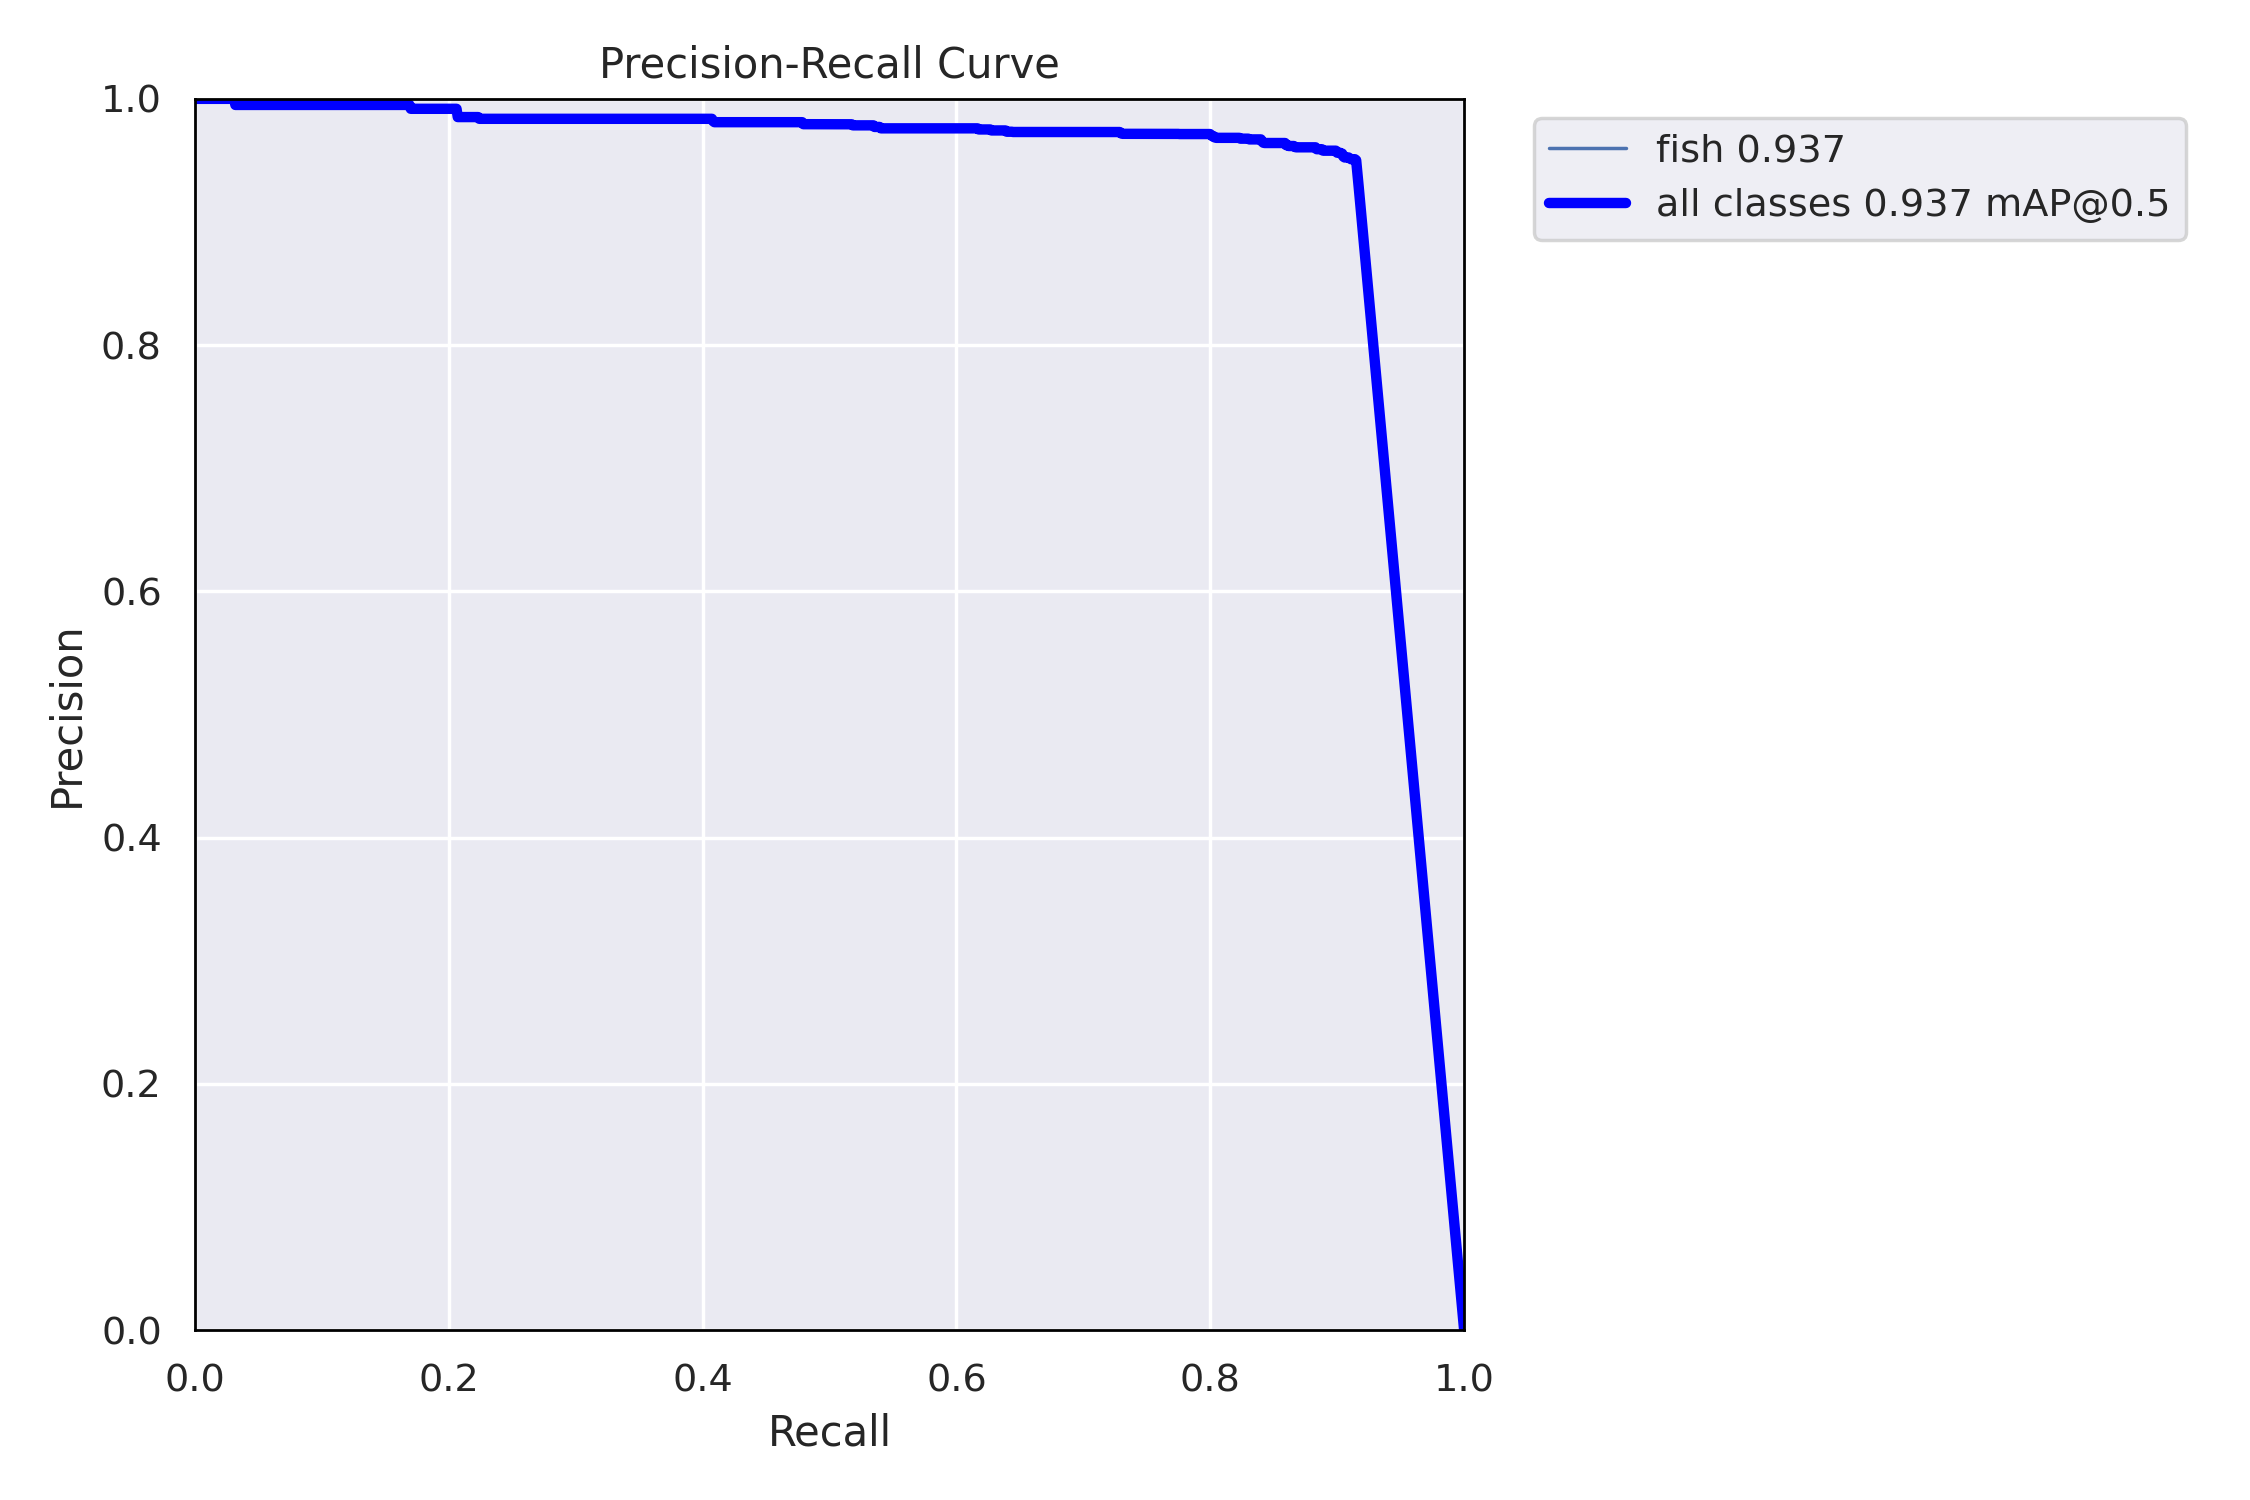

In [17]:
from IPython.display import Image

Image(filename=f"{HOME}/yolov9/runs/val/fish_yolo_c_final2/PR_curve.png", width=1000)